# Importing Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nbformat as nbf
import seaborn as sns
from docx import Document
from docx.shared import Inches, Pt
import os

In [2]:
# File path (provided by user upload)
csv_path = "C:/Users/user/Downloads/urban_commute_population.csv"

# 1. Load dataset and inspect

In [3]:
df = pd.read_csv(csv_path)
df_shape = df.shape
columns = df.columns.tolist()

# Display brief info
print(f"Loaded dataset: {csv_path}")
print(f"Shape: {df_shape}")
print("Columns:", columns)

Loaded dataset: C:/Users/user/Downloads/urban_commute_population.csv
Shape: (100000, 13)
Columns: ['PersonID', 'Age', 'Gender', 'Income_USD', 'Income_Bracket', 'Neighborhood_Density', 'Car_Ownership', 'Remote_Work_Days', 'Commute_Method', 'Distance_km', 'Commute_Time_min', 'Has_Parked', 'Children']


In [4]:
# Quick cleaning / normalization guesses for expected column names:
# We'll try to find likely column names for the variables described in the prompt.
expected_keywords = {
    "distance": ["distance","commute_distance","Commute distance","commute_distance_km","commute_distance (km)".lower()],
    "time": ["time","commute_time","commute_time_minutes","commute_time (minutes)".lower()],
    "remote": ["remote","remote_work_days","remote_work_days_per_week","work_from_home_days","WFH_days"],
    "cars": ["car","car_ownership","cars","num_cars","car ownership","Car ownership".lower()],
    "method": ["commute_method","method","Commute method","commute method".lower()],
    "income_bracket": ["income_bracket","income bracket","Income bracket".lower(), "income_group"]
}

# We'll locate plausible columns by case-insensitive matching.
lower_cols = [c.lower() for c in columns]
col_map = {}
for key, keywords in expected_keywords.items():
    found = None
    for kw in keywords:
        for i,c in enumerate(lower_cols):
            if kw in c or c in kw:
                found = columns[i]
                break
        if found:
            break
    col_map[key] = found

col_map

{'distance': 'Distance_km',
 'time': 'Commute_Time_min',
 'remote': 'Remote_Work_Days',
 'cars': 'Car_Ownership',
 'method': 'Commute_Method',
 'income_bracket': 'Income_Bracket'}

In [5]:
# For safety, print a small sample of head to see actual names
display(df.head())

# Based on found column names, define variables to use. If any are missing, try common fallback names.
distance_col = col_map.get("distance") or next((c for c in columns if "distance" in c.lower()), None)
time_col = col_map.get("time") or next((c for c in columns if "time" in c.lower()), None)
remote_col = col_map.get("remote") or next((c for c in columns if "remote" in c.lower() or "wfh" in c.lower()), None)
cars_col = col_map.get("cars") or next((c for c in columns if "car" in c.lower()), None)
method_col = col_map.get("method") or next((c for c in columns if "commute" in c.lower() or "method" in c.lower()), None)
income_bracket_col = col_map.get("income_bracket") or next((c for c in columns if "income" in c.lower() and "brack" in c.lower()), None)

print("\nInferred columns:")
print("distance_col:", distance_col)
print("time_col:", time_col)
print("remote_col:", remote_col)
print("cars_col:", cars_col)
print("method_col:", method_col)
print("income_bracket_col:", income_bracket_col)

,PersonID,Age,Gender,Income_USD,Income_Bracket,Neighborhood_Density,Car_Ownership,Remote_Work_Days,Commute_Method,Distance_km,Commute_Time_min,Has_Parked,Children
0,1,41,Female,48218,Medium,Low,1,0,Car,25.41,46.7,True,0
1,2,27,Other,63678,Medium,Low,0,0,Car,13.32,39.4,True,0
2,3,46,Other,193312,High,Medium,2,1,Car,10.57,23.5,True,0
3,4,48,Male,116228,High,High,0,1,Car,8.29,21.9,False,0
4,5,17,Male,24600,Low,Low,2,4,WFH,0.00,0.0,False,2



Inferred columns:
distance_col: Distance_km
time_col: Commute_Time_min
remote_col: Remote_Work_Days
cars_col: Car_Ownership
method_col: Commute_Method
income_bracket_col: Income_Bracket


# 2. Draw three samples of size 100

In [6]:
n = 100
convenience = df.iloc[:n].copy()
simple_random = df.sample(n=n, replace=False, random_state=42).copy()

# For stratified sample proportionate to income bracket:
if income_bracket_col is not None:
    # compute proportions for each bracket in population
    prop = df[income_bracket_col].value_counts(normalize=True)
    # number to sample per stratum (round, but ensure sum equals n)
    counts = (prop * n).round().astype(int)
    # adjust rounding difference
    diff = n - counts.sum()
    if diff != 0:
        # adjust largest strata(s)
        for i in range(abs(diff)):
            idx = counts.idxmax() if diff>0 else counts.idxmin()
            counts.loc[idx] += 1 if diff>0 else -1
    # sample per stratum
    stratified_parts = []
    for bracket, cnt in counts.items():
        part = df[df[income_bracket_col]==bracket].sample(n=cnt, replace=False, random_state=42) if cnt>0 else pd.DataFrame(columns=df.columns)
        stratified_parts.append(part)
    stratified = pd.concat(stratified_parts).sample(frac=1, random_state=42).reset_index(drop=True)
else:
    stratified = None

# 3. Function to compute summaries for a dataset

In [7]:
def summarize_dataset(d):
    summary = {}
    if distance_col in d.columns:
        summary['distance_mean'] = d[distance_col].mean()
        summary['distance_median'] = d[distance_col].median()
        summary['distance_std'] = d[distance_col].std()
    if time_col in d.columns:
        summary['time_mean'] = d[time_col].mean()
        summary['time_median'] = d[time_col].median()
        summary['time_std'] = d[time_col].std()
    if remote_col in d.columns:
        summary['remote_mean'] = d[remote_col].mean()
        summary['remote_median'] = d[remote_col].median()
        summary['remote_std'] = d[remote_col].std()
    if cars_col in d.columns:
        summary['cars_mean'] = d[cars_col].mean()
        summary['cars_mode'] = d[cars_col].mode().iloc[0] if not d[cars_col].mode().empty else np.nan
    if method_col in d.columns:
        summary['method_counts'] = d[method_col].value_counts()
        summary['method_props'] = d[method_col].value_counts(normalize=True)
    if income_bracket_col in d.columns:
        summary['income_counts'] = d[income_bracket_col].value_counts()
        summary['income_props'] = d[income_bracket_col].value_counts(normalize=True)
    return summary

pop_summary = summarize_dataset(df)
conv_summary = summarize_dataset(convenience)
srs_summary = summarize_dataset(simple_random)
strat_summary = summarize_dataset(stratified) if stratified is not None else None

# 4. Compare sample statistics against population

In [8]:
def compare_stats(pop_sum, samp_sum, metric_keys):
    comp = {}
    for key in metric_keys:
        if key in pop_sum and key in samp_sum:
            popv = pop_sum[key]
            samv = samp_sum[key]
            comp[key] = {"population": popv, "sample": samv, "abs_error": abs(samv-popv), "pct_error": abs(samv-popv)/abs(popv) if popv!=0 else np.nan}
    return comp

metric_keys = ['distance_mean','time_mean','remote_mean','cars_mean']
conv_comp = compare_stats(pop_summary, conv_summary, metric_keys)
srs_comp = compare_stats(pop_summary, srs_summary, metric_keys)
strat_comp = compare_stats(pop_summary, strat_summary, metric_keys) if stratified is not None else None

# 5. Visualizations

#### Commute Distance & Commute Time Distributions

C:\Users\user\AppData\Local\Temp\ipykernel_10636\1089396564.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('Income_Bracket').apply(


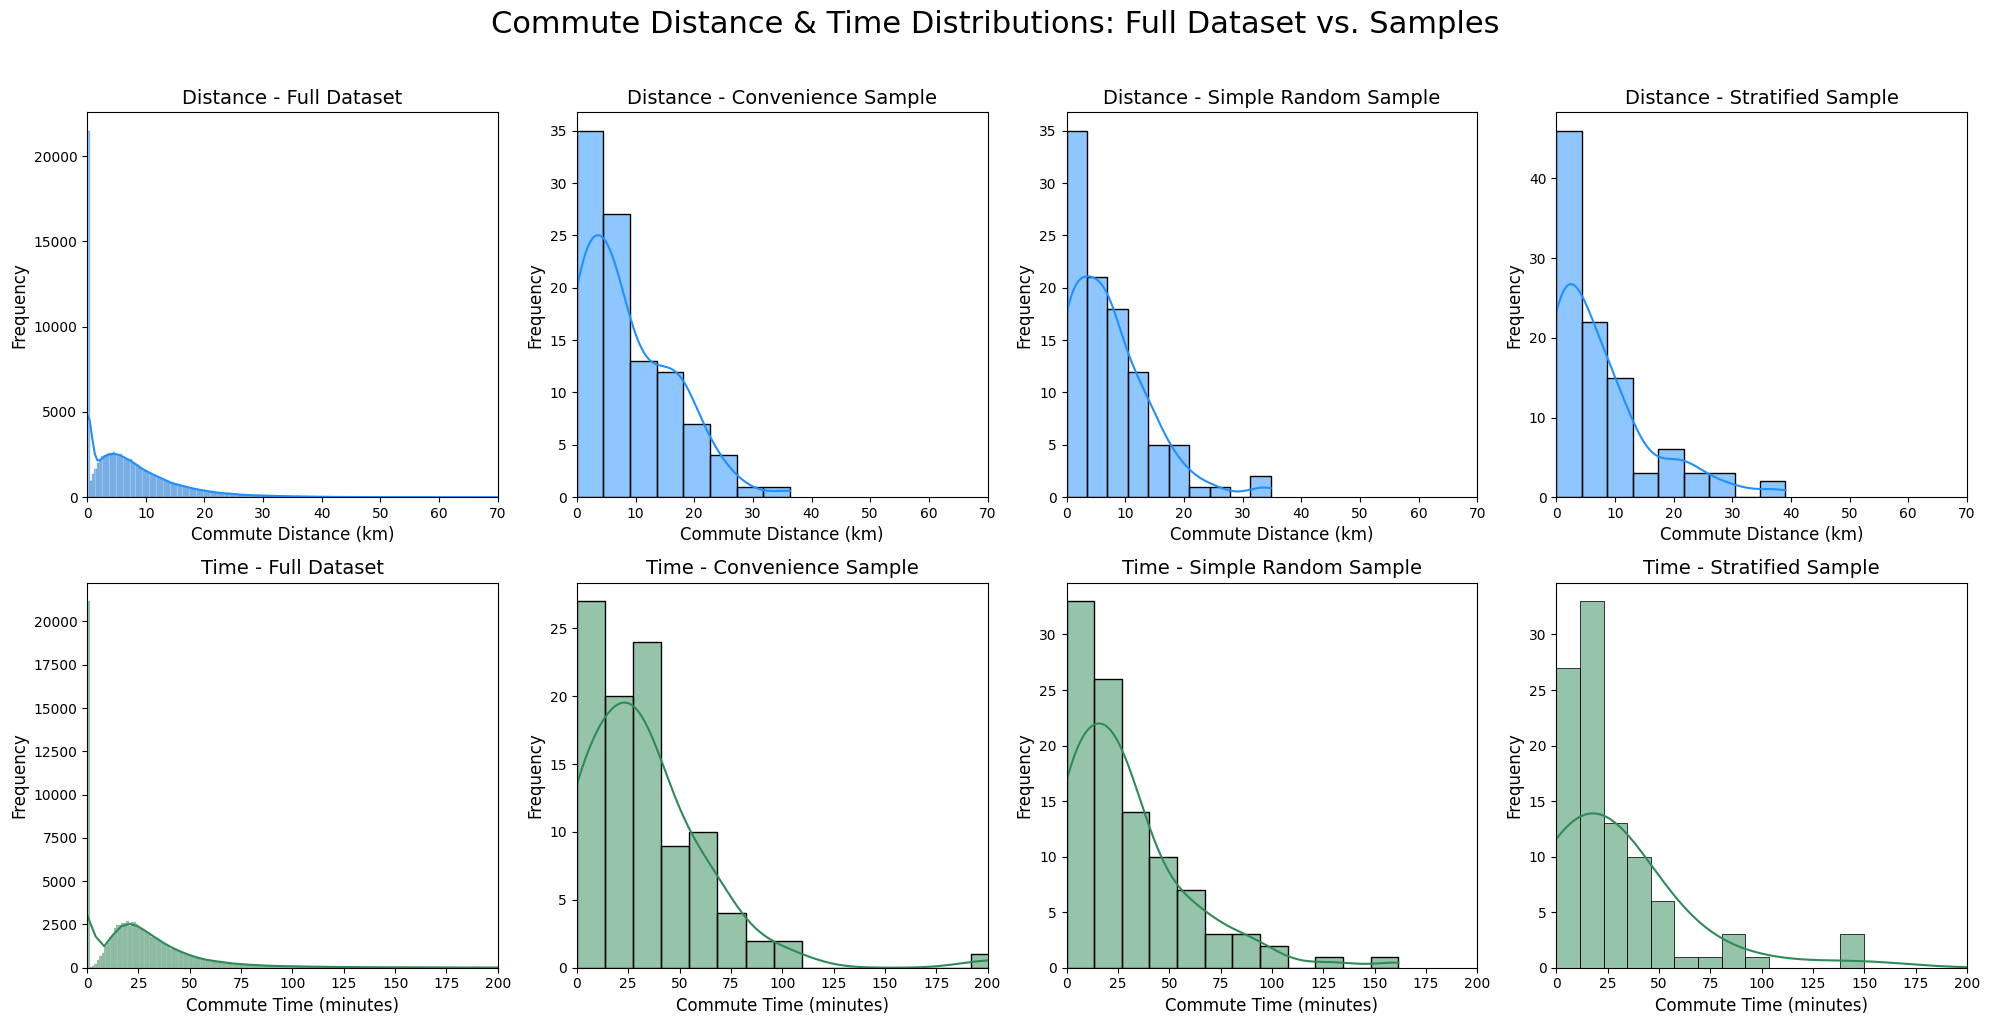

In [9]:
# Create the samples
# 1. Convenience sample (first 100 records)
convenience_sample = df.head(100).copy()

# 2. Simple random sample (without replacement)
simple_random_sample = df.sample(n=100, replace=False, random_state=42).copy()

# 3. Stratified sample proportionate to income bracket
income_bracket_proportions = df['Income_Bracket'].value_counts(normalize=True)
stratified_sample_sizes = (income_bracket_proportions * 100).round().astype(int)

# Adjust for rounding to ensure total sample size is 100
total_size = stratified_sample_sizes.sum()
if total_size > 100:
    stratified_sample_sizes[stratified_sample_sizes.idxmax()] -= (total_size - 100)
elif total_size < 100:
    stratified_sample_sizes[stratified_sample_sizes.idxmax()] += (100 - total_size)

def get_stratified_sample(df, sizes):
    return df.groupby('Income_Bracket').apply(
        lambda x: x.sample(n=sizes[x.name], random_state=42, replace=False)
    )

stratified_sample = get_stratified_sample(df, stratified_sample_sizes)

# Store datasets
datasets = {
    'Full Dataset': df,
    'Convenience Sample': convenience_sample,
    'Simple Random Sample': simple_random_sample,
    'Stratified Sample': stratified_sample
}

# ---- Generate Visualizations ----
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
fig.suptitle('Commute Distance & Time Distributions: Full Dataset vs. Samples', fontsize=22, y=1.02)

# Row 1: Commute Distance
for i, (name, data) in enumerate(datasets.items()):
    sns.histplot(data['Distance_km'], kde=True, ax=axes[0, i], color='dodgerblue')
    axes[0, i].set_title(f'Distance - {name}', fontsize=14)
    axes[0, i].set_xlabel('Commute Distance (km)', fontsize=12)
    axes[0, i].set_ylabel('Frequency', fontsize=12)
    axes[0, i].set_xlim(0, 70)

# Row 2: Commute Time
for i, (name, data) in enumerate(datasets.items()):
    sns.histplot(data['Commute_Time_min'], kde=True, ax=axes[1, i], color='seagreen')
    axes[1, i].set_title(f'Time - {name}', fontsize=14)
    axes[1, i].set_xlabel('Commute Time (minutes)', fontsize=12)
    axes[1, i].set_ylabel('Frequency', fontsize=12)
    axes[1, i].set_xlim(0, 200)

plt.tight_layout()
plt.show()


#### Comparison of Remote Work Days per Week

C:\Users\user\AppData\Local\Temp\ipykernel_10636\1948143557.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(
C:\Users\user\AppData\Local\Temp\ipykernel_10636\1948143557.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(
C:\Users\user\AppData\Local\Temp\ipykernel_10636\1948143557.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(
C:\Users\user\AppData\Local\Temp\ipykernel_10636\1948143557.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to 

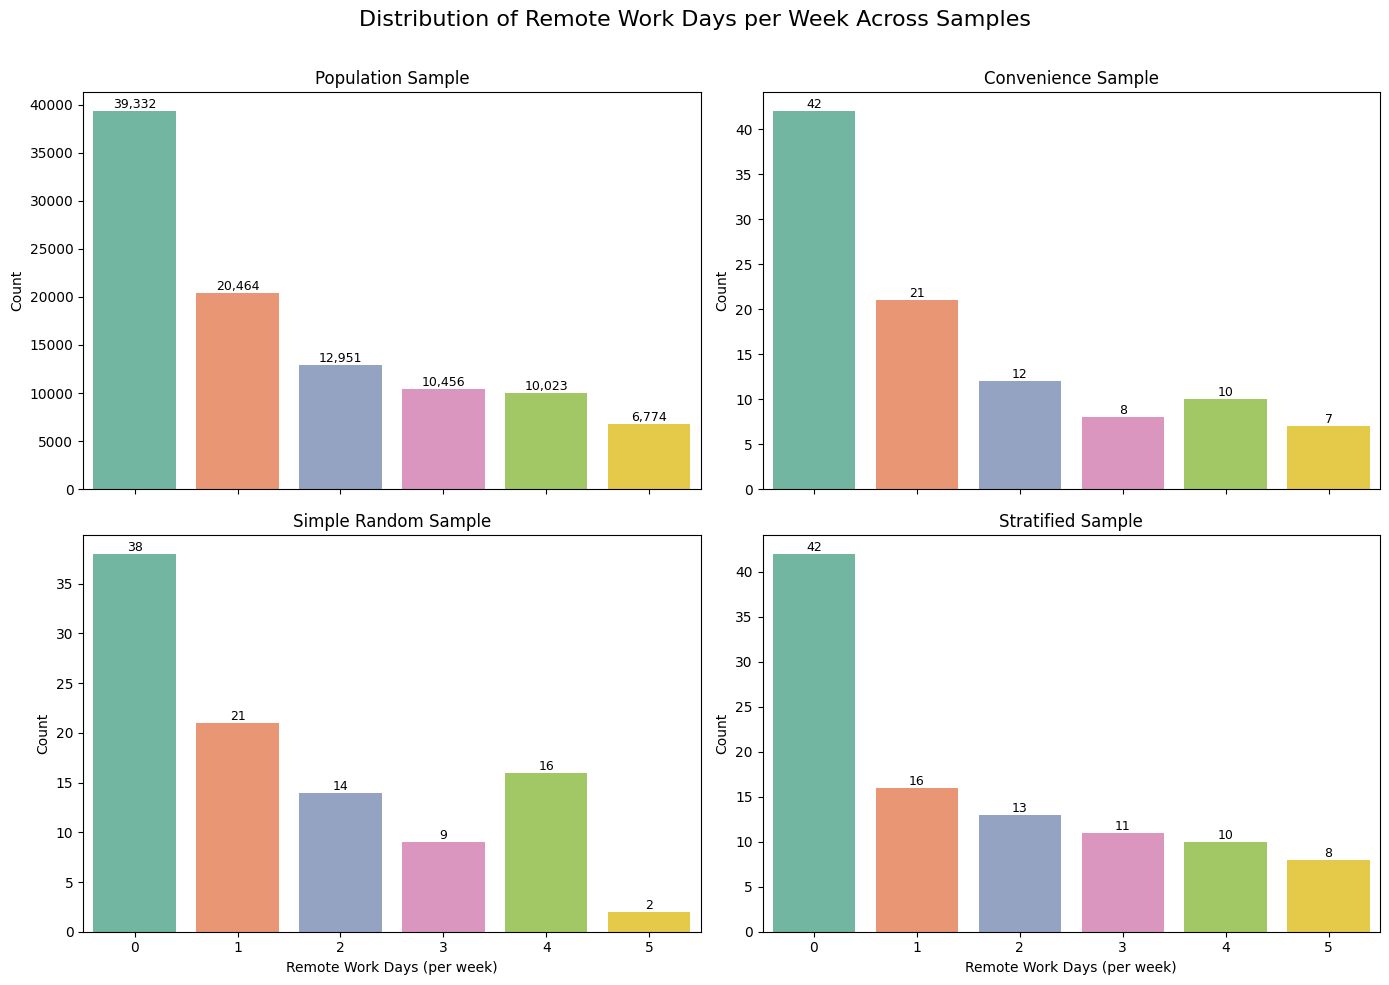

In [10]:
# ---- Combine all datasets into one dataframe ----
plot_df = pd.concat([
    df.assign(Sample="Population"),
    convenience.assign(Sample="Convenience"),
    simple_random.assign(Sample="Simple Random"),
    stratified.assign(Sample="Stratified") if stratified is not None else pd.DataFrame()
])

# Create subplots for each sample
samples = plot_df["Sample"].unique()
fig, axes = plt.subplots(2, 2, figsize=(14,10), sharex=True)

# Flatten axes for easy iteration
axes = axes.flatten()

for i, sample in enumerate(samples):
    subset = plot_df[plot_df["Sample"] == sample]
    ax = axes[i]
    sns.countplot(
        data=subset,
        x="Remote_Work_Days",
        palette="Set2",
        ax=ax
    )
    ax.set_title(f"{sample} Sample")
    ax.set_xlabel("Remote Work Days (per week)")
    ax.set_ylabel("Count")

    # Add data labels (formatted with comma separator, no decimals)
    for p in ax.patches:
        height = int(p.get_height())  # convert to integer
        ax.annotate(f"{height:,}", 
                    (p.get_x() + p.get_width()/2., height),
                    ha="center", va="bottom", fontsize=9)

# Hide unused subplot if stratified is missing
if len(samples) < len(axes):
    for j in range(len(samples), len(axes)):
        axes[j].axis("off")

plt.suptitle("Distribution of Remote Work Days per Week Across Samples", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

#### Car Ownership Comparison

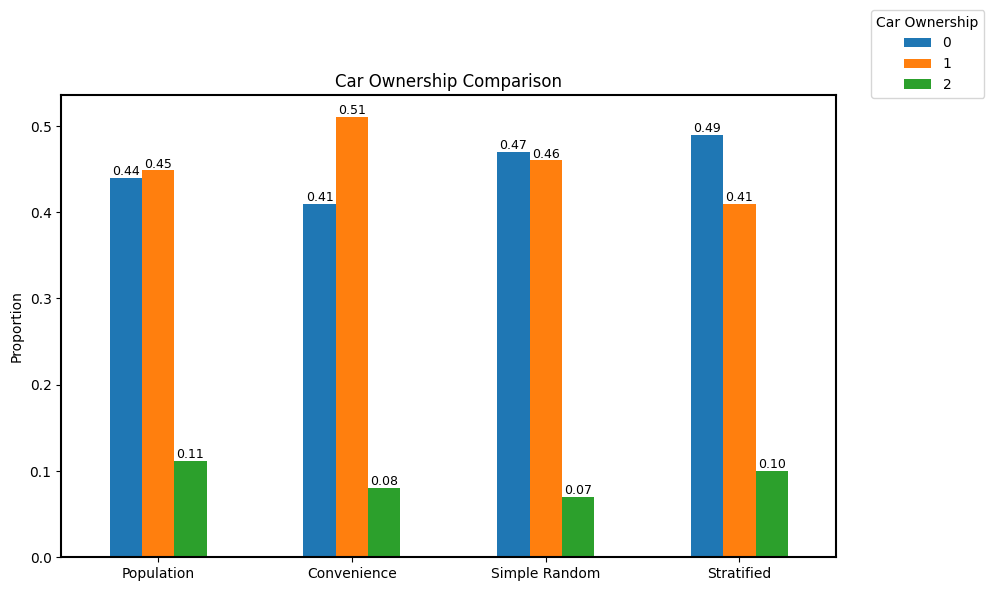

In [11]:
car_pop = df["Car_Ownership"].value_counts(normalize=True)
car_con = convenience["Car_Ownership"].value_counts(normalize=True)
car_srs = simple_random["Car_Ownership"].value_counts(normalize=True)
car_strat = stratified["Car_Ownership"].value_counts(normalize=True) if stratified is not None else None

car_df = pd.DataFrame({
    "Population": car_pop,
    "Convenience": car_con,
    "Simple Random": car_srs,
    "Stratified": car_strat
}).T

ax = car_df.plot(kind="bar", figsize=(10,6))
plt.title("Car Ownership Comparison")
plt.ylabel("Proportion")
plt.xticks(rotation=0)

# Place legend at top
plt.legend(title="Car Ownership", loc="upper right", bbox_to_anchor=(1.2, 1.2))

# Add labels
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=9)

# Add black border around entire plot
for spine in ax.spines.values():
    spine.set_edgecolor("black")
    spine.set_linewidth(1.5)

plt.show()

#### Commute Method Comparison

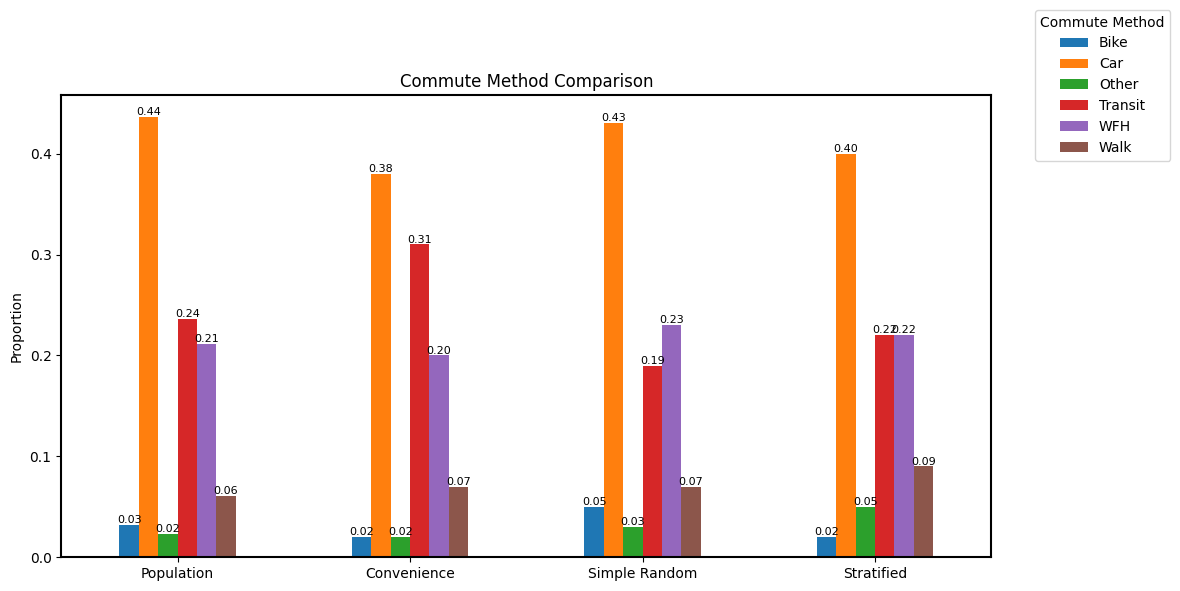

In [12]:
method_pop = df["Commute_Method"].value_counts(normalize=True)
method_con = convenience["Commute_Method"].value_counts(normalize=True)
method_srs = simple_random["Commute_Method"].value_counts(normalize=True)
method_strat = stratified["Commute_Method"].value_counts(normalize=True) if stratified is not None else None

method_df = pd.DataFrame({
    "Population": method_pop,
    "Convenience": method_con,
    "Simple Random": method_srs,
    "Stratified": method_strat
}).T

ax = method_df.plot(kind="bar", figsize=(12,6))
plt.title("Commute Method Comparison")
plt.ylabel("Proportion")
plt.xticks(rotation=0)

# Place legend at top
plt.legend(title="Commute Method", loc="upper right", bbox_to_anchor=(1.2, 1.2))

# Add labels
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=8)
    
# Add black border around entire plot
for spine in ax.spines.values():
    spine.set_edgecolor("black")
    spine.set_linewidth(1.5)

plt.show()

# 6. Prepare a concise results table for means and errors

In [13]:
def make_results_df(pop_sum, conv_sum, srs_sum, strat_sum):
    rows = []
    metrics = ['distance_mean','time_mean','remote_mean','cars_mean']
    for m in metrics:
        popv = pop_sum.get(m, np.nan)
        convv = conv_sum.get(m, np.nan)
        srsv = srs_sum.get(m, np.nan)
        stratv = strat_sum.get(m, np.nan) if strat_sum is not None else np.nan
        rows.append({
            'metric': m,
            'population': popv,
            'convenience': convv,
            'convenience_abs_error': abs(convv-popv) if not np.isnan(convv) else np.nan,
            'srs': srsv,
            'srs_abs_error': abs(srsv-popv) if not np.isnan(srsv) else np.nan,
            'stratified': stratv,
            'stratified_abs_error': abs(stratv-popv) if not np.isnan(stratv) else np.nan
        })
    return pd.DataFrame(rows)

results_df = make_results_df(pop_summary, conv_summary, srs_summary, strat_summary)
results_df
# import caas_jupyter_tools as cjt
# cjt.display_dataframe_to_user("Sampling comparison (means & errors)", results_df)

,metric,population,convenience,convenience_abs_error,srs,srs_abs_error,stratified,stratified_abs_error
0,distance_mean,7.436249,8.6196,1.183351,7.2477,0.188549,7.4753,0.039051
1,time_mean,28.746749,33.7870,5.040251,28.9780,0.231251,34.4790,5.732251
2,remote_mean,1.516960,1.4400,0.076960,1.5000,0.016960,1.5500,0.033040
3,cars_mean,0.672290,0.6700,0.002290,0.6000,0.072290,0.6100,0.062290
